In [86]:
import pandas as pd
import numpy as np

# Problem

>The Babel fish is small, yellow, leech-like - and probably the oddest thing in the universe. It feeds on brain wave energy, absorbing all unconscious frequencies and then excreting telepathically a matrix formed from the conscious frequencies and nerve signals picked up from the speech centres of the brain, the practical upshot of which is that if you stick one in your ear, you can instantly understand anything said to you in any form of language: the speech you hear decodes the brain wave matrix. [The Hitchhiker's Guide to the Galaxy]()


Today we will try to build (several) translation systems.

![image.png](https://miro.medium.com/max/1780/1*YtTQh-C2_DgiPk_0T1xBlw.jpeg)

![image.png](https://miro.medium.com/max/1732/1*XuR_iuPOuY-8i5A3cGmcBw.png)

# Dataset

## Loading the pandas dataframe

Data is downloaded from "http://www.manythings.org/anki/". It's a set of English phrases and the equivalent French translations.

The goal of course would be to create a system that takes one of them and outputs the other one.

In [3]:
raw = pd.read_parquet("./_data/fra_df.hdf5")
raw.head()

,English,French,French_tokens,English_tokens,English_length,French_length
0,Go.,Va !,"[Va, !]","[Go, .]",2,2
1,Hi.,Salut !,"[Salut, !]","[Hi, .]",2,2
2,Run!,Cours !,"[Cours, !]","[Run, !]",2,2
3,Run!,Courez !,"[Courez, !]","[Run, !]",2,2
4,Wow!,Ça alors !,"[Ça, alors, !]","[Wow, !]",2,3


# Model 1: Word dictionary

The first implementation is a really simple one: 
* Find a real "dictionary" (a set of Franch to English words)
* Parse the French phrase and substitute all the words with the English correspondents.

It will yield rubish translations of course, but it's a good starting place.

The dictionary is taken from [here](https://github.com/pquentin/wiktionary-translations). Btw, it took me a great deal of time to really find this dictionary. You'd think that a 1-1 mapping of words between 2 really common languages should be easy especially for a pair of really popular languages).

In [1]:
!wget https://raw.githubusercontent.com/pquentin/wiktionary-translations/master/frwiktionary-20140612-euradicfmt.csv -O ./_data/fre_eng.csv

--2019-09-04 23:37:33--  https://raw.githubusercontent.com/pquentin/wiktionary-translations/master/frwiktionary-20140612-euradicfmt.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2950339 (2,8M) [text/plain]
Saving to: ‘./_data/fre_eng.csv’

./_data/fre_eng.csv 100%[===================>]   2,81M   526KB/s    in 5,2s    

2019-09-04 23:37:39 (552 KB/s) - ‘./_data/fre_eng.csv’ saved [2950339/2950339]



We're going to load the dataset to see what we can work with. Note that we have to figure out some hoops in order to properly load this.

In [4]:
df_fre_eng = pd.read_csv("./_data/fre_eng.csv", sep=";", header=None, index_col=0, names=["French", "FrePOS", "Dict", "English", "EngPOS", "UNK"]).drop(columns=["UNK"])
df_fre_eng.head()

,FrePOS,Dict,English,EngPOS
French,,,,
1000e,J,TR-FR-EN,1000th,J
100e,J,TR-FR-EN,100th,J
100 mètres haies,S,TR-FR-EN,100 metre hurdles,S
100 mètres,S,TR-FR-EN,100 metres,S
10 Downing Street,S,TR-FR-EN,10 Downing Street,S


Before we use the dictionary, let's load an example from the `to-be-translated` dataset to see an example. The snippet bellow also sketches a bit what we're going to do.

In [5]:
sample = np.random.randint(raw.shape[0])

for word in raw.iloc[sample].French_tokens:
    print(word)

Est-ce
tellement
mal
?


Applying some formalism and good software engineering, we're going to define some functions for later use, and documentation.

In [87]:
def random_sample():
    """
    Returns a random sample id from the database
    """
    return np.random.randint(raw.shape[0])

def get_sample(sample_id=None):
    """
    Returns the tokens of a random sample specified by the given sample id.
    """
    if sample_id is None:
        sample_id = random_sample()
    return raw.iloc[sample_id].French_tokens

get_sample()

array(['À', 'quelle', 'heure', "l'atterrissage", 'de', "l'avion",
       'est-il', 'prévu', '?'], dtype=object)

Now that we've loaded the datasets and we have a index on the `French` column, we can use it to query for a translation

In [7]:
df_fre_eng.loc['maison']

,FrePOS,Dict,English,EngPOS
French,,,,
maison,J,TR-FR-EN,homemade,J
maison,S,TR-FR-EN,home,S
maison,S,TR-FR-EN,house,S
maison,S,TR-FR-EN,outfit,S


And we get our first major `problem`: **polysemy**

> the coexistence of many possible meanings for a word or phrase.

How would you deal with this?

* The dictionary also has a `part-of-speach` column that we can *maybe* use (if we really want to go on that route and learn a lot grammar rules) 
* Me, I've chosen the first value :D

In [88]:
def get_equivalent(fre_word):
    """
    Returns the equivalent word translation of the given french word, 
    using the loaded vocabulary
    """
    try:
        return df_fre_eng.loc[fre_word, "English"].iloc[0]
    except:
        return f"<?>"
    
get_equivalent("Maison")

'<?>'

Second `problem`: **capitalisation**

Of course we can't expect to have all possible captalisation forms *a Word CAN hAVE, in oUr* dictionary so we're going to need a normalization scheme.

Keeping it simple, we will convert everything to lower-case, and strip all the leading and ending space chars.

In [90]:
def normalize(word):
    """
    Performs a simple normalization.
    """
    return word.lower().strip()

normalize("Si")

'si'

We are now ready to try our translation "model". We will simply substitute all the words in french with their english equivalents.

In [91]:
fre_tokens = get_sample()
eng_tokens = [get_equivalent(normalize(word)) for word in fre_tokens]
list(zip(fre_tokens, eng_tokens))

[('Je', '<?>'),
 ('veux', '<?>'),
 ('acheter', 'buy'),
 ('une', '<?>'),
 ('montre', 'watch'),
 ('plus', 'and'),
 ('chère', 'cheer'),
 ('.', '<?>')]

## Trying with a better dictionary

Maybe a better, more comprehensive dictionary would eliminate most of those `<?>` words...

In [109]:
!wget https://raw.githubusercontent.com/freedict/fd-dictionaries/master/eng-fra/eng-fra.tei -O ./_data/eng-fra.tei

--2019-09-05 11:34:05--  https://raw.githubusercontent.com/freedict/fd-dictionaries/master/eng-fra/eng-fra.tei
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3329108 (3,2M) [text/plain]
Saving to: ‘./_data/eng-fra.tei’

./_data/eng-fra.tei 100%[===================>]   3,17M  5,57MB/s    in 0,6s    

2019-09-05 11:34:07 (5,57 MB/s) - ‘./_data/eng-fra.tei’ saved [3329108/3329108]



In [110]:
!wget https://raw.githubusercontent.com/freedict/fd-dictionaries/master/shared/freedict-dictionary.css -O ./_data/freedict-dictionary.css

--2019-09-05 11:37:40--  https://raw.githubusercontent.com/freedict/fd-dictionaries/master/shared/freedict-dictionary.css
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4783 (4,7K) [text/plain]
Saving to: ‘./_data/freedict-dictionary.css’

./_data/freedict-di 100%[===================>]   4,67K  --.-KB/s    in 0s      

2019-09-05 11:37:40 (41,1 MB/s) - ‘./_data/freedict-dictionary.css’ saved [4783/4783]



In [11]:
import xml.etree.ElementTree as et 
xtree = et.parse("_data/eng-fra.xml")
xroot = xtree.getroot()

In [12]:
def get_entries():
    """
    I know, it's XML..
    """
    for entry in xroot.findall("{http://www.tei-c.org/ns/1.0}text")[0].getchildren()[0].findall("{http://www.tei-c.org/ns/1.0}entry"):
        yield entry
        
entry = next(get_entries())
entry

<Element '{http://www.tei-c.org/ns/1.0}entry' at 0x7feb4618a548>

In [13]:
def get_pairs(entry):
    """
    XML parsing function. Yields pairs of words (french, english)
    """
    form  = entry.find("{http://www.tei-c.org/ns/1.0}form")
    senses = entry.findall("{http://www.tei-c.org/ns/1.0}sense")
    orth = form.find("{http://www.tei-c.org/ns/1.0}orth")
    english = orth.text
    for sense in senses:
        try:
            french = sense.find("{http://www.tei-c.org/ns/1.0}cit").find("{http://www.tei-c.org/ns/1.0}quote").text
            yield normalize(french), normalize(english)
        except:
            print(sense)
list(get_pairs(entry))

[('abc', 'abc')]

In [14]:
pairs = np.array([pair for entry in get_entries() for pair in get_pairs(entry)])

Ok, let's encapsulate these in a `Pandas` `DataFrame` and set the index on the `French` column so we have fast lookup time.

In [15]:
df_fre_eng_2 = pd.DataFrame(data=pairs, columns=["French", "English"]).set_index("French")
df_fre_eng_2.head()

,English
French,
abc,abc
abécédaire,abc book
sida,aids
abkhasie,abkhazia
abkhasien,abkhazian


We're now ready to write the translation function again, using this new datastructure.

In [92]:
def get_equivalent(fre_word):
    """
    Returns the equivalent word translation of the given french word, 
    using the loaded vocabulary
    """
    try:
        return df_fre_eng.loc[fre_word, "English"].iloc[0]
    except:
        try:
            return df_fre_eng_2.loc[fre_word, "English"].iloc[0]
        except:
            return "<?>"
    
get_equivalent("nous")

'<?>'

Unfortunately, it doesn't work any better..

In [95]:
fre_tokens = get_sample()
eng_tokens = [get_equivalent(normalize(word)) for word in fre_tokens]
list(zip(fre_tokens, eng_tokens))

[('Je', '<?>'), ('suis', '<?>'), ('fiable', 'reliable'), ('.', '<?>')]

`Problems`:

* we can't find all the words
    * upgrate to a better dictionary
    * still won't be able to include all the irregular forms a word will have 
* can't handle polisemy
   
**Conclusions**
* this approach is not that feasible

# Model 2: Word embeddings

Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words from the vocabulary are mapped to vectors of real numbers.

This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. This can be contrasted with the crisp but fragile representation in a bag of words model where, unless explicitly managed, different words have different representations, regardless of how they are used.

Word embeddings are such a common appearence in NLP that it's not worth describind them in more details. There are a ton of online resources that can give you more details about them.

The main idea of using them is that since an embedding encapsulates **semantic** representation, then we can solve the **polysemi** problem of the Model 1 above.

In [96]:
class DictNumpyEmbeddings():
    def __init__(self, id2word, embed):
        self._id2word = id2word
        self.embed = embed
        self.word2id = {word: id for id, word in enumerate(id2word)}
        self._n_words = embed.shape[0]
        self._n_dim = embed.shape[1]
        assert len(id2word) == embed.shape[
            0], 'The length of the vocabulary should be equal to the number of the embeddings'

    @property
    def matrix(self) -> np.array:
        return self.embed

    @property
    def n_words(self):
        return self._n_words

    @property
    def n_dim(self):
        return self._n_dim

    def __iter__(self):
        for word in self._id2word:
            yield word

    def __contains__(self, key):
        return key in self.word2id

    def __getitem__(self, word: str) -> np.array:
        if word not in self.word2id:
            return None
        return self.embed[self.word2id[word]]

    @property
    def id2word(self) -> np.array:
        return self._id2word

    def apply_transform(self, transform: str):
        """
        Apply the given transformation to the vector space

        Right-multiplies given transform with embeddings E:
            E = E * transform

        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        self.embed = np.matmul(self.embed, transmat)

In [19]:
class NumpyReader():
    def __init__(self, vector_file=''):
        self.vector_file = vector_file

    def load(self):
        with np.load(self.vector_file) as store:
            return DictNumpyEmbeddings(store['vocab'], store['embed'])

In [20]:
french_embeddings = NumpyReader("./_data/wiki.fr.small.npz").load()

In [99]:
french_embeddings['je'].shape

(300,)

You can see above that each of the (we use FastText) embeddings has 300 dimensions.

Now if we take a few words (somewhat) at random, and print them on the first few dimensions you can start notice that for pairs of words that are similar, some dimensions "line-up" that is, have roughly the same values (i.e. the same color on the plot). This means that on those dimensions (whatever they may represent, no one really knows..) these words have are really similar.

For example `me` and `you` have lots of close values on lots of dimensions, some possibly describing the `refers to humans` capacity, or other common charateristics. 

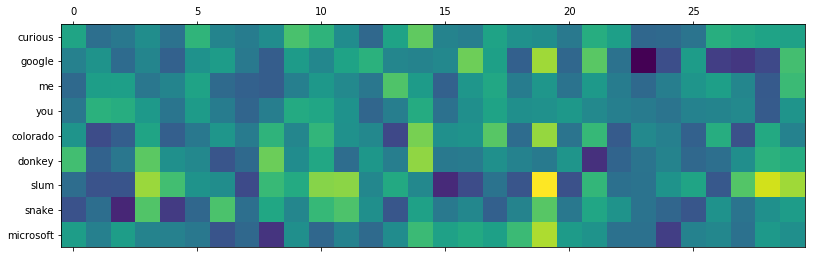

In [24]:
from matplotlib import pyplot as plt

def show_words(words):
    emb_matrix = [english_embeddings[word][:30].astype(np.float32) for word in words]
    plt.matshow(emb_matrix)
    plt.yticks(np.arange(len(words)), labels=words)
    
words = ["curious", "google", "me", "you", "colorado", "donkey", "slum", "snake","microsoft"]
show_words(words)

A few experiments with word embeddings

[('curious', 'colorado'),
 ('google', 'me'),
 ('me', 'you'),
 ('you', 'me'),
 ('colorado', 'snake'),
 ('donkey', 'colorado'),
 ('slum', 'snake'),
 ('snake', 'colorado'),
 ('microsoft', 'google')]

<Figure size 1080x864 with 0 Axes>

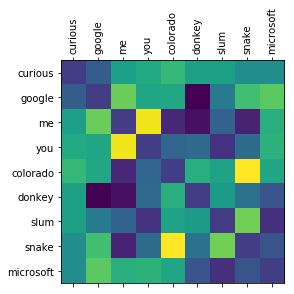

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_matirx(words):
    word_emb = [english_embeddings[word][:30].astype(np.float32) for word in words]
    return cosine_similarity(word_emb, word_emb)

matrix = cosine_matirx(words)
matrix[np.arange(matrix.shape[0]), np.arange(matrix.shape[0])] = 0
plt.figure(figsize=(15,12))
plt.matshow(matrix)
plt.xticks(np.arange(len(words)), labels=words, rotation=90)
plt.yticks(np.arange(len(words)), labels=words);

[(words[i], words[amax]) for i, amax in enumerate(np.argmax(matrix, axis=0))]

A good measure for comparing two embeddings is by using the `cosine_similarity` metric. We use it above to compute a squared similarity matrix by comparing each word by the others. The highest values (max. is 1) represents words really similar. Close to 0 are words that have not relation, and close to -1 are words that should represent opposite concepts.

*Note: Although `cosine_similarity(word, word) == 1` so our fist diagonal should be 1, we've set it to 0 so to highlight the other similarities.* 

Of course, in order to make a translation we need both languages.

In [ ]:
english_embeddings = NumpyReader("./_data/wiki.en.small.npz").load()

The main idea of our second algorithm is a follows:
* convert the french phrase to word tokens 
* convert the tokens to embeddings
* for each embedding search the corresponding embedding in the english language that is the closest to the current one
* do this for all french tokens

The problem is that embeddings are trained **independently** for each language. So the resulting embedding don't overlap really well. 

Think about this as viewing the same object (the world - expressed / shaped by roughly the same words) but viewed from diffrent angles.

Each training, depending from where the random weights were initialized from, will end up viewing the world from a slightly different angle so the language (through the words that describe it) will be a little tilted.

Fortunately for us we recently [have a way](https://arxiv.org/pdf/1804.07745.pdf) to align the two spaces, and have a common bilingual (or multilingual for that matter) embeddings space. There's even a set of word embeddings already alligned for you by Facebook on the original [FastText site](https://fasttext.cc/docs/en/aligned-vectors.html).

We're also using some pieaces of code from [here](https://github.com/babylonhealth/fastText_multilingual/blob/master/fasttext.py).

In [110]:
def lazy_property(fn):
    '''
    Decorator that makes a property lazy-evaluated.
    '''
    attr_name = '_lazy_' + fn.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, fn(self))
        return getattr(self, attr_name)

    return _lazy_property

class EmbeddingSpace:
    def __init__(self, embed):
        self.embeddings = embed

    @lazy_property
    def embeddings_normalized(self):
        return EmbeddingSpace.normalised(self.embeddings.matrix)

    def translate_nearest_neighbour(self, source_vector):
        """Obtain translation of source_vector using nearest neighbour retrieval"""
        similarity_vector = np.matmul(self.embeddings_normalized, source_vector)
        print(self.embeddings_normalized.shape, source_vector.shape, similarity_vector.shape)
        target_ids = np.argsort(similarity_vector)[::-1][:10]
        print(target_ids)
        return [self.embeddings.id2word[target_id] for target_id in target_ids]

    @classmethod
    def normalised(cls, mat, axis=-1, order=2):
        """Utility function to normalise the rows of a numpy array."""
        norm = np.linalg.norm(
            mat, axis=axis, ord=order, keepdims=True)
        norm[norm == 0] = 1
        return mat / norm

    @classmethod
    def cosine_similarity(cls, vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
               (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

french_space = EmbeddingSpace(french_embeddings)
english_space = EmbeddingSpace(english_embeddings)

We're going to thest this out.. Let's take the word `je` from French.

In [103]:
target_word = french_embeddings['je']
target_word.shape

(300,)

Computing the `dot product` between it and all the embeddings of the english language will yield the top part of the `cosine_similarity` formula.

K(X, Y) = <X, Y> / (||X||*||Y||)

Note that we're using embeddings already normalized by the l2 norm of each word (i.e. Emb(Y) = Orig(X) / ||Orig(X)||, and the l2 norm of Y (`je` the word we're comparing all the vocabulary with) has the same norm for all words (constant).

This means that the order of similarity is the same only by doing the `dot product` without further dividing by the (constant) ||Y||. That's why we do an `argsort` directly.

In [106]:
similarity_vector = np.matmul(english_space.embeddings_normalized, target_word)
similarity_vector.shape

(2519368,)

In [107]:
ids_sorted = np.argsort(similarity_vector)[::-1]
ids_sorted[:10]

array([ 2411,  8284,    48,    26,  9424, 19584, 15942,   281,   898,
         492])

The most similar indexes of word in the english vocabulary, similar to `je`. These are represented by the list of words bellow:

In [109]:
[english_space.embeddings.id2word[target_id] for target_id in ids_sorted[:10]]

['myself',
 'btw',
 'you',
 'i',
 'honestly',
 'fwiw',
 'anyways',
 'think',
 'sure',
 've']

In [111]:
english_space.translate_nearest_neighbour(french_embeddings['je'])

(2519368, 300) (300,) (2519368,)
[ 2411  8284    48    26  9424 19584 15942   281   898   492]


['myself',
 'btw',
 'you',
 'i',
 'honestly',
 'fwiw',
 'anyways',
 'think',
 'sure',
 've']

Now that we have a way for jumping from one language to the other with the help of alligned ambeddings, let's demonstrate how our (naive) algorithm (version 2) works.

In [28]:
def get_equivalent(word):
    return english_space.translate_nearest_neighbour(french_embeddings[word])

In [107]:
from tqdm import tqdm_notebook as tqdm
fre_tokens = get_sample()
eng_tokens = [get_equivalent(normalize(word))[0] for word in tqdm(fre_tokens)]
list(zip(fre_tokens, eng_tokens))

[('Il', 'he'),
 ('y', '¿quíeres'),
 ('a', 'had'),
 ('un', 'a'),
 ('parc', 'park'),
 ('au', 'the'),
 ('milieu', 'mid'),
 ('de', 'of'),
 ('la', 'the'),
 ('ville', 'city'),
 ('.', '⁃')]

Solves:
* every word should have a corespondant translated (no more <?> words)
    * because the vocabulary is really large now
* compund words
* synonyms

Problems:
* slow! (2 min / phrase)
* some words are not perfectly alligned
* some words are not english (`¿quíeres`)
* 1-1 translation doesn't work (`au` -> `<in> the`)
* the sequencing of words doesn't have any role in the translation (BOW)

# Model 3: RNN

We will build a model whose main idea is to **predict the next word**, given:
* a **full** french phrase (eg. "Il fait bien!")
* some initial english words

## Data

Since we need to allocate some weights and these should be fixed, we need to know, in advance the **maximum** size of a phrase, in each language.

In [29]:
max_eng_size = raw.English_length.max()
max_fre_size = raw.French_length.max()

max_eng_size, max_fre_size

(51, 60)

## Vocabulary

We also need to build some auxiliary datastructures that will allow us to:
* vectorize
* un-vectorize
* normalize words
* add padding
* un-padd

### Id2Word

In [30]:
subsample = 10000
subsample = -1 # all words

In [31]:
from functools import reduce
from tqdm import tqdm_notebook as tqdm
# from tqdm import trange

def flatten(series: list) -> list:
    """
    Flattens the given list and returns a list of (unique) tokens
    """
    return list(reduce(lambda collect, value: collect | set(value), series, set()))

def unique(vocabulary: list) -> list:
    return list(set(vocabulary))

def lower(vocabulary: list) -> list:
    return list(map(str.lower, vocabulary))

id2en = sorted(unique(lower(flatten(tqdm(raw.English_tokens[:subsample])))))
id2fr = sorted(unique(lower(flatten(tqdm(raw.French_tokens[:subsample])))))

max_eng_size = raw.English_length[:subsample].max()
max_fre_size = raw.French_length[:subsample].max()

len(id2en), len(id2fr)

(14200, 28614)

### Special words

The model will rely on a set of special words that will be used to signal the start, ending and possibly padding characters which we will add to the dataset.

In [32]:
START_WORD = ">"
STOP_WORD = "_"

SPECIAL_WORDS = [START_WORD, STOP_WORD]

assert set(SPECIAL_WORDS) & set(id2en) == set()
assert set(SPECIAL_WORDS) & set(id2fr) == set()

We add the special words as the first elements of each vocabulary list

In [33]:
id2en = SPECIAL_WORDS + id2en
id2fr = SPECIAL_WORDS + id2fr

It's always a good idea to save the vocabulary to ensure that reruning the notebook will not result in a reordering of the words (and invalidate subsequently trained and saved models).

In [995]:
np.savez("./_data/fr_en_vocabulary.npz", 
         id2en=id2en, 
         id2fr=id2fr, 
         max_eng_size=max_eng_size, 
         max_fre_size=max_fre_size, 
         start_word=START_WORD,
         stop_word=STOP_WORD
        )

## Reversed lookup dictionary

In [34]:
from typing import Dict

def word2id(elements: list) -> Dict[str, int]:
    return {word: _id for _id, word in enumerate(elements)}
    
en2id = word2id(tqdm(id2en))
fr2id = word2id(tqdm(id2fr))

# Test that for the first 100 elements the two datastructures are conssitent
for i in range(100):
    assert fr2id[id2fr[i]] == i
    assert en2id[id2en[i]] == i
    
# Test that we have the special words in front
assert fr2id[START_WORD] == 0
assert en2id[STOP_WORD] == 1

In [35]:
id2fr[:10]

['>', '_', '!', '$', '%', '&', "'", "''", "'maison", "'oublie"]

## Data formatting

We mark a "phrase" as a sequence of words, encapsulated by the `START_WORD` and `STOP_WORD`.

In [36]:
def phrase(tokens: list) -> list:
    """
    Padds the token list with START and STOP words
    """
    return [START_WORD] + lower(tokens) + [STOP_WORD]

# Each phrase increases with 2 more elements so the maxiums change as well
max_eng_size = max_eng_size + 2
max_fre_size = max_fre_size + 2

phrase(['Va', '!'])

['>', 'va', '!', '_']

In [112]:
from typing import List, Dict

def indexed(tokens: List[str], vocabulary: Dict[str, int]) -> List[int]:
    """
    Returns a vectorized list for the given token list. 
    The vectorisation is done using the given vocabulary mapping. 
    """
    return [vocabulary[word] for word in tokens]

from functools import partial
fr_indexed = partial(indexed, vocabulary=fr2id)
en_indexed = partial(indexed, vocabulary=en2id)

indexed(phrase(['Va', '!']), vocabulary=fr2id), fr_indexed(phrase(['Comment', 'ca', 'va', '?']))

([0, 27005, 2, 1], [0, 4402, 3149, 27005, 234, 1])

Also, we will padd words (because we use batch training and each element in a batch should have the same size). This means that e need to right padd all the phrases with a `null` char until all are equal.

In [38]:
def padd_right(tokens: list, fixed_size=3, padd="|")-> list:
    """
    Adds enought padding characters to the right of the given list to as to make it a fixed size == fixed_size
    """
    l = len(tokens)
    to_padd = max(0, fixed_size - l)
    return list(tokens) + ([padd] * to_padd)

padded = padd_right([1, 2, 3], fixed_size=10, padd=0)

fixed_length_fr = partial(padd_right, fixed_size=max_fre_size, padd=STOP_WORD)
fixed_length_en = partial(padd_right, fixed_size=max_eng_size, padd=STOP_WORD)

assert len(padded) == 10
assert padded[-1] == 0
padded

[1, 2, 3, 0, 0, 0, 0, 0, 0, 0]

## Debug functions

In [39]:
def to_str(tokens: List[object]):
    """
    Pretty prints a list of tokens
    """
    return " ".join(map(str, tokens))
    
print(to_str(fixed_length_fr([1, 2, 3])))

1 2 3 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [42]:
def decode(indexed_tokens: List[int], vocabulary: List[str]) -> List[str]:
    """
    Decodes a list of token ids to into a list of words, using the given vocabulary
    """
    return [vocabulary[_id] for _id in indexed_tokens]

en_decode = partial(decode, vocabulary=id2en)
fr_decode = partial(decode, vocabulary=id2fr)

to_str(fr_decode(encode_input[0]))

'va ! _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

## Training set

In [41]:
fixed_length_fre_generator = map(lambda tokens: fr_indexed(fixed_length_fr(lower(tokens))), tqdm(raw.French_tokens[:subsample]))
fixed_length_eng_generator = map(lambda tokens: en_indexed(fixed_length_en(phrase(tokens))), tqdm(raw.English_tokens[:subsample]))

encode_input = np.array(list(fixed_length_fre_generator), dtype=np.int32)
decode_input = np.array(list(fixed_length_eng_generator), dtype=np.int32)

encode_input.shape, decode_input.shape

((160871, 62), (160871, 53))

In [43]:
decode_output = np.full_like(decode_input, fill_value=en2id[STOP_WORD])

decode_output[:,:-1] = decode_input[:, 1:]

# Test that the decode_output is one timestep ahead
assert np.alltrue(decode_output[:, :max_eng_size-1] == decode_input[:, 1:max_eng_size])

decode_output.shape

(160871, 53)

In [44]:
decode_input[0], decode_output[0]

(array([   0, 5597,   20,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array([5597,   20,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32))

In [117]:
np.array(fr_decode(decode_input[0]))

array(['>', 'craignez-vous', '...', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_'], dtype='<U13')

So the model needs to learn that:
```
0 -> 5597, after that
5597 -> 20, after that
20 -> 1, after that
1 -> 1, etc.
```
all in one go!

Even though the model doesn't actually predict `5597`, `20`, `1`, `1` at each step, on next steps of the training we will asume that those were the correct answers and continue (with the same state) with thsese (also called teacher-forcing).

In [45]:
from sklearn.model_selection import train_test_split
encode_input_train, encode_input_test, decode_input_train, decode_input_test, decode_output_train, decode_output_test = train_test_split(encode_input, decode_input, decode_output, test_size=0.2, shuffle=True)

encode_input_train.shape, decode_input_train.shape, decode_output_train.shape

((128696, 62), (128696, 53), (128696, 53))

### Training generators

The full training data (lables), when one-hot-encoded take arround 11GB of RAM space, which is larger than we might want. We use a generator to split batches and one-hot-encode a batch at a time. This is more time consuming but way more space efficient.

In [46]:
from keras.utils import to_categorical

english_language_vocabulary_size = len(id2en)
batch_size = 64

def data_generator(encode_input, decode_input, decode_output, batch_size=32, subsample=10000):
    assert encode_input.shape[0] == decode_input.shape[0] == decode_output.shape[0]
    length = encode_input.shape[0] if not subsample else subsample
    while True:
        for i in range(0, length, batch_size):
            yield [encode_input[i:i+batch_size, :], decode_input[i:i+batch_size, :]], to_categorical(decode_output[i:i+batch_size, :], num_classes=english_language_vocabulary_size)
            
gen = data_generator(encode_input_train, decode_input_train, decode_output_train, batch_size=batch_size)
[inp, tch], out = next(gen)
inp.shape, tch.shape, out.shape

Using TensorFlow backend.


((64, 62), (64, 53), (64, 53, 14202))

In [47]:
sample = 11

def _fr(data):
    return to_str(fr_decode(data))[:100]

def _en(data):
    return to_str(en_decode(data))[:100]

_fr(inp[sample]), _en(tch[sample]), _en(np.argmax(out[sample], axis=-1))

('je suis désolé , je ne parle pas français . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ',
 "> i 'm sorry , i do n't speak french . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _",
 "i 'm sorry , i do n't speak french . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")

## Model implementation

In [48]:
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from keras.models import Model
from keras.layers import concatenate
from keras import backend as K

In [49]:
# Note: turns out that we can pass the shape shape=(None,) and this will make the model a variable length one!
fre = Input(shape=(max_fre_size,), name="FreTokens")
eng = Input(shape=(max_eng_size,), name="EngTokens")

fre_emb = Embedding(input_dim=len(id2fr), output_dim=200, name="FreEmbeds")
eng_emb = Embedding(input_dim=len(id2en), output_dim=200, name="EngEmbeds")

# TODO: this shouldn't have used return_state=True!!
fre_lstm = LSTM(201, name="FreLSTM", return_state=True)

# Although we don't need in the trainign session, the internal state of the decoder part
# (so we could pass return_state=False) we want to reuse the same layer in the decoder model
# used for inference, so we use retrurn_state=True after all 
eng_lstm = LSTM(201, name="EngLSTM", return_state=True, return_sequences=True)


# We recieve three things here because we've set return_state=True.
# We also get the internal states of the RNN (hidden, constants)
# 
# hidden = <tf.Tensor 'FreLSTM_4/while/Exit_3:0' shape=(?, 10) dtype=float32>,
# constants = <tf.Tensor 'FreLSTM_4/while/Exit_4:0' shape=(?, 10) dtype=float32>
single_fre_out, fre_hidden_state, fre_constants = fre_lstm(fre_emb(fre))

# At this stage, the single_fre_out is irrelevant to us. What we want to get 
# is only the internal state of the LSTM
_ = single_fre_out

# Initialize the English LSTM with the hidden state that we got by passing through 
# all the words in the French sentence. We basically start from the point that LSTM stopped and we wish to 
# "go back in time" if we can, but reversing in a different language (English).
all_eng_out, eng_hidden_state, eng_constants = eng_lstm(eng_emb(eng), initial_state=[fre_hidden_state, fre_constants])

# I'm still unsure what's the difference bewteen applying TimeDistributed vs. Dense layer directly.
# Both seem to act the same
#
# We will need to reuse the trained Dense layer so we can requre it to the inference inputs
eng_decode = Dense(len(id2en), activation="softmax")
output = eng_decode(all_eng_out)

model = Model(inputs=[fre, eng], outputs=[output])
model.summary()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FreTokens (InputLayer)          (None, 62)           0                                            
__________________________________________________________________________________________________
EngTokens (InputLayer)          (None, 53)           0                                            
__________________________________________________________________________________________________
FreEmbeds (Embedding)           (None, 62, 200)      5723200     FreTokens[0][0]                  
__________________________________________________________________________________________________
EngEmbeds (Embedding)           (None, 53, 200)      2840400     EngTokens[0][0]                  
__________________________________________________________________________________________________
FreLSTM (L

Note:
* that the model is quite large.

## Training

In [50]:
subsample_train = None # encode_input_train.shape[0]
batch_size = 64
subsample_test = None  # encode_input_test.shape[0]
epochs = 100

steps_per_epoch_train = (subsample_train if subsample_train else encode_input_train.shape[0]) // batch_size
steps_per_epoch_test = (subsample_test if subsample_test else encode_input_test.shape[0]) // batch_size

train_gen = data_generator(encode_input_train, decode_input_train, decode_output_train, batch_size=batch_size, subsample=subsample_train)
test_gen = data_generator(encode_input_test, decode_input_test, decode_output_test, batch_size=batch_size, subsample=subsample_test)

history2 = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch_train, epochs=epochs, validation_data=test_gen, validation_steps=steps_per_epoch_test)

W0905 17:40:47.624840 140650209232704 deprecation.py:323] From /home/tecknoworks/~Envs/deep3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0905 17:40:48.635371 140650209232704 deprecation.py:323] From /home/tecknoworks/~Envs/deep3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/100
  23/2010 [..............................] - ETA: 17:15 - loss: 3.3896

KeyboardInterrupt: 

In [229]:
model.save_weights("./_data/fre_eng_lstm_fixed.ep101.hdf5",overwrite=True)

In [83]:
model.load_weights("./_data/fre_eng_lstm_fixed.ep100.hdf5")

## Inference model

In [52]:
def strip_indexed(tokens):
    """
    Function that strips all the decorations from a indexed training sequence (containing ids).
    
    It removes the following:
    * the initial START_WORD
    * the ending STOP_WORD
    * all the padding words added with fixed_length variant functions

    """
    if type(tokens) != list:
        tokens = tokens.tolist()
        
    # exclude the initial START_WORD, the STOP_WORD and everything after it (padding words)
    stop_word_id = en2id[STOP_WORD]
    if stop_word_id in tokens:
        return tokens[0:tokens.index(en2id[STOP_WORD])]
    else:
        return tokens

def strip_plaintext(tokens):
    """
    Function that strips all the decorations from a plaintext training sequence (containing actual words).
    
    It removes the following:
    * the initial START_WORD
    * the ending STOP_WORD
    * all the padding words added with fixed_length variant functions

    """

    # exclude the initial START_WORD, the STOP_WORD and everything after it (padding words)
    if STOP_WORD in tokens:
        return tokens[0:tokens.index(STOP_WORD)]
    else:
        return tokens

def strip(tokens):
    """
    Function that strips all the decorations from a training sequence.
    It removes the following:
    * the initial START_WORD
    * the ending STOP_WORD
    * all the padding words added with fixed_length variant functions
    
    This function can be applied to both indexed or plaintext sequences.
    """
    
    def __are_plaintext(tokens):
        # Heuristic to test if the tokens are in plaintext or not.
        # Assumed plaintext if known plaintext words (almost always guaranteed to be present) 
        # are included among the tokens.
        # 
        # These signal words are:
        # START_WORD, STOP_WORD
        return STOP_WORD in tokens or START_WORD in tokens 
        
    if __are_plaintext(tokens):
        return strip_plaintext(tokens)
    else:
        return strip_indexed(tokens)

strip(fr_decode(encode_input_test[0]))

['je', 'pense', 'que', 'je', 'peux', 'réparer', 'ça', '.']

In [53]:
tokens = ["Allez", "!"]

def fr_input(tokens):
    return np.expand_dims(np.array(fr_indexed(fixed_length_fr(lower(tokens)))), 0)

def en_input(tokens: list):
    return np.expand_dims(np.array(en_indexed(fixed_length_en(tokens))), 0)

fr_input(tokens), en_input([START_WORD])

(array([[992,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1]]),
 array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]))

Trying to manually add one word at a time

In [54]:
tokens = encode_input_train[12]
tokens

array([17938, 26738, 26929, 16713,  6732, 14413,    19,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1],
      dtype=int32)

In [55]:
np.array(fr_decode(tokens))

array(['on', 'trouvera', 'un', 'moyen', 'de', "l'utiliser", '.', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
       '_'], dtype='<U10')

In [56]:
strip_plaintext(fr_decode(tokens))

['on', 'trouvera', 'un', 'moyen', 'de', "l'utiliser", '.']

In [57]:
tokens = encode_input_train[12]
tokens = strip_plaintext(fr_decode(tokens))
fr_input(tokens)

array([[17938, 26738, 26929, 16713,  6732, 14413,    19,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]])

In [119]:
model.predict(x=[fr_input(tokens), en_input([START_WORD])]).shape

(1, 53, 14202)

In [120]:
# tokens = ["Allez", "a", "la", "voiture", "avec", "nous", "."]
tokens = encode_input_train[12]
tokens = strip_plaintext(fr_decode(tokens))

pred = [START_WORD]
while pred[-1] != STOP_WORD:
    p = np.argmax(model.predict(x=[fr_input(tokens), en_input(pred)]), axis=-1)[0][len(pred)-1]
    pred.append(id2en[p])
    print(id2en[p])
" ".join(tokens), " ".join(pred)

we
find
a
way
to
happen
to
it
.
_


("on trouvera un moyen de l'utiliser .", '> we find a way to happen to it . _')

Before implementing the generating loop I'm going to quickly simulate it in order to see that everything has been traing correctly and I've not screwed up. 

*Note: I've been blocked at the bellow couple of cells much, much more than it seems, as it was the main debug point that helped me see that the model was not performing and made me go back and fix the model (several times).*

In [128]:
tokens = ["Elle", "est", "une", "belle", "jeune"]
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she", "is"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she", "is", "a"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she", "is", "a", "beautiful"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she", "is", "a", "beautiful", "university"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "she", "is", "a", "beautiful", "university", "her"])]), axis=-1)[0])[:10])

['she', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['she', 'is', '_', '_', '_', '_', '_', '_', '_', '_']
['she', 'is', 'a', '_', '_', '_', '_', '_', '_', '_']
['she', 'is', 'a', 'beautiful', 'thank', '_', '_', '_', '_', '_']
['she', 'is', 'a', 'beautiful', 'university', '_', '_', '_', '_', '_']
['she', 'is', 'a', 'beautiful', 'university', 'her', '_', '_', '_', '_']
['she', 'is', 'a', 'beautiful', 'university', 'her', '.', '_', '_', '_']


In [129]:
tokens = ["pourquoi", "l'as-tu", "gardé", "secret", "?"] # taken from training set
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did", "you"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did", "you", "keep"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did", "you", "keep", "it"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did", "you", "keep", "it", "a"])]), axis=-1)[0])[:10])
print(en_decode(np.argmax(model.predict(x=[fr_input(tokens), en_input([START_WORD, "why", "did", "you", "keep", "it", "a", "secret"])]), axis=-1)[0])[:10])

['why', 'why', '_', '_', '_', '_', '_', '_', '_', '_']
['why', 'did', 'did', '_', '_', '_', '_', '_', '_', '_']
['why', 'did', 'you', 'tell', '_', '_', '_', '_', '_', '_']
['why', 'did', 'you', 'keep', '_', '_', '_', '_', '_', '_']
['why', 'did', 'you', 'keep', 'that', '_', '_', '_', '_', '_']
['why', 'did', 'you', 'keep', 'that', 'a', '_', '_', '_', '_']
['why', 'did', 'you', 'keep', 'that', 'a', 'secret', '_', '_', '_']
['why', 'did', 'you', 'keep', 'that', 'a', 'secret', '?', '_', '_']


We now need to separate the decoder layers into a new keras Model so we can use it later on.

In [70]:
# get encoder states
fre_var = Input(shape=(None,), name="FreVariableToken")
_, fre_hidden_var, fre_const_var = fre_lstm(fre_emb(fre_var))
encoder = Model(inputs=fre_var, outputs=[fre_hidden_var, fre_const_var])
encoder.summary()

# Make the initial states of the decoder, input symbols
eng_one = Input(shape=(1,), name="EngSingleToken")
hidden_state = Input(shape=(201,), name="EngHiddLSTM")
const_state = Input(shape=(201,), name="EngConsLSTM")

# wire the input states to the trained LSTM
# we are reusing the eng_emb trained layer to convert token ids into embeddings
# (?) If we pass the initial_state to the LSTM do we still need to reuse the already trained one?
# (?) i.e. does the LSTM have any other state only persisted in the trained LSTM instance?
# (?) EDIT: There are some Wx , Wh matrices what are indeed trained and only stored internally
all_eng_out, eng_hidden_state, eng_constants = eng_lstm(eng_emb(eng_one), initial_state=[hidden_state, const_state])

# wire the all steps output to the trained eng_decode Dense layer
one_hot_words = eng_decode(all_eng_out)

decoder = Model(inputs=[eng_one, hidden_state, const_state], outputs=[one_hot_words, eng_hidden_state, eng_constants])
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FreVariableToken (InputLayer (None, None)              0         
_________________________________________________________________
FreEmbeds (Embedding)        multiple                  5723200   
_________________________________________________________________
FreLSTM (LSTM)               [(None, 201), (None, 201) 323208    
Total params: 6,046,408
Trainable params: 6,046,408
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EngSingleToken (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________


The last piece now is going recursevly until we get to a STOP_WORD token.

*Note: The code bellow also contains lots of debug code and output because getting the right tensors to line up wasn't as straigh forward as I'd planned*

In [130]:
def is_not_finished(generated_english_word_ids):
    """
    Checks if we have a stopping event encountered.
    Resons to stop generating words:
    * STOP_WORD encountered
    * max_lenght words generated
    """
    id_last_word_predicted = generated_english_word_ids[-1]
    
    is_stop_word_hit = id_last_word_predicted == en2id[STOP_WORD]
    is_max_length_hit = len(generated_english_word_ids) == max_eng_size
    
    return not is_stop_word_hit and not is_max_length_hit 


def translate(fre_tokens: List[str], debug=True) -> List[str]:
    """
    Translates the given sentence from French to English.
    
    The input of this function is a list of french word tokens.
    """
    # Scan the full french phrase and return the hidden state of the LSTM
    # This will be used to initialize the first step of the LSTM english decoder
    french_phrase = fr_input(fre_tokens)[0]
    
    # Somehow it matters to have the full padded string as input
    # Sending only the actuall tokens without the padding considerably degrades the performance
#     french_phrase = fr_indexed(lower(fre_tokens + [STOP_WORD] * 45))
    
    if debug:
        print(f"---------------------------")
        print(f"[0] French: \t{to_str(fr_decode(french_phrase))[:80]}")
        print(f"[0] Indexed: \t{french_phrase[:10]}\n")
    
    eng_tokens = [START_WORD]
    eng_inp = en_indexed(lower(eng_tokens))

    [hidden], [const] = encoder.predict([[french_phrase]])
#     print(hidden.shape, const.shape)
#     print(f"[0] Hidden:\t{np.round(hidden, 2)[:10]}")
#     print(f"[0] Const:\t{np.round(const, 2)[:10]}")

#     print(hidden[:, 0], const[:, 0])
        
    id_last_word_predicted = eng_inp[-1]
#     id_stop_word = en2id[STOP_WORD]
    
    # Continously make predictions until we have a stopping event
    while is_not_finished(eng_inp):
#         fixed_eng_inp = fixed_length_en([eng_inp[-1]], padd=id_stop_word)
        fixed_eng_inp = [eng_inp[-1]]
    
        if debug:
            print(f"[{len(eng_inp)-1}] Hidden:\t{np.round(hidden, 2)[:10]}")
            print(f"[{len(eng_inp)-1}] Const:\t{np.round(const, 2)[:10]}")
            print(f"[{len(eng_inp)-1}] Input: \t{to_str(en_decode(fixed_eng_inp))}")

        # pass the decoder LSTM hidden staten and the last word we've just predicted
        [[[one_hot_words]], [hidden], [const]] = decoder.predict([[fixed_eng_inp], [hidden], [const]])
#         [[[one_hot_words], [o2]], [hidden, h1], [const, c1]] = decoder.predict([[fixed_eng_inp, fixed_eng_inp], [hidden, hidden], [const, const]])
        print(one_hot_words.shape, hidden.shape, const.shape)
        
        # one_hot_words.shape = (53, 14203)
        # predicted_words = (53,) 
        predicted_words = np.argmax(one_hot_words, axis=-1)
        print(predicted_words.shape)
        
        # the last word is the one corresponding to the last seen french word (if we discard the START_WORD) 
        # id_last_word_predicted = predicted_words[len(eng_inp) - 1]
        id_last_word_predicted = predicted_words
        
        if debug:
            # print the top words predicted, for each timestep
            top_words = np.argsort(one_hot_words)[::-1][:10]
            print(f"[{len(eng_inp)-1}] Top: \t{[id2en[_id] for _id in top_words]}")
            print(f"[{len(eng_inp)-1}] Score: \t{[np.round(one_hot_words[_id], 2) for _id in top_words]}")
            print(f"[{len(eng_inp)-1}] Pred: \t`{to_str(en_decode(eng_inp))}` ~~~: {id2en[id_last_word_predicted]}\n")
            
        eng_inp.append(id_last_word_predicted)
        

    return en_decode(eng_inp)

to_str(translate(["Allez", "a", "la", "maison", "avec", "nous", "."]))
to_str(translate(["Va", "!"]))

---------------------------
[0] French: 	allez a la maison avec nous . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
[0] Indexed: 	[  992   236 14552 15685  2176 17655    19     1     1     1]

[0] Hidden:	[ 0.08  0.03  0.   -0.    0.46 -0.14  0.   -0.26  0.06 -0.  ]
[0] Const:	[ 0.13  0.16  1.09 -0.07 21.51 -0.37  0.   -0.94  2.74 -0.89]
[0] Input: 	>
(14202,) (201,) (201,)
()
[0] Top: 	['he', 'go', 'come', 'home', 'we', 'his', 'look', 'get', 'i', 'from']
[0] Score: 	[0.57, 0.33, 0.03, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]
[0] Pred: 	`>` ~~~: he

[1] Hidden:	[ 0.07  0.34 -0.06  0.73  0.83 -0.05  0.14 -0.64  0.93 -0.32]
[1] Const:	[ 0.1   0.35 -0.06  0.93  9.08 -0.05  0.19 -1.36  1.66 -0.44]
[1] Input: 	he
(14202,) (201,) (201,)
()
[1] Top: 	["'s", 'is', 'has', 'lives', 'went', 'left', 'goes', 'turned', 'leaves', 'cut']
[1] Score: 	[0.76, 0.1, 0.04, 0.03, 0.02, 0.02, 0.01, 0.0, 0.0, 0.0]
[1] Pred: 	`> he` ~~~: 's

[2] Hidden:	[ 0.11  0.18 -0.53 -0.02  0.71 -0.09  0.19 -0.71  0.9 

'> go . _'

In the output above you can ignore the `Hidden` and `Constant` lines. But you cn observe the progression and the possible candidate words along with their probabilities:
    
    [3] Input: 	home
    [3] Top: 	['with', '.', 'has', "'s", 'and', 'get', 'left', 'is', 'go', 'have']
    [3] Score: 	[0.59, 0.11, 0.07, 0.05, 0.04, 0.02, 0.02, 0.01, 0.01, 0.01]
    [3] Pred: 	`> he 's home` ~~~: with

.. means that:
* on predicting the 4rd word ([3])
* the previous choosen token (that triggers the computation) being `home` (and considering the current hidden state)
* The next top words are `with, ., has, 's etc..`
* Their scores are (respectively) `[0.59, 0.11, 0.07, ..]`
* The choosen prediction for the sequence `> he \'s home` is `with` 

# Model 4: Beam search

In computer science, beam search is a heuristic search algorithm that explores a graph by expanding the most promising node in a limited set. Beam search is an optimization of best-first search that reduces its memory requirements.

The model aboves does a decent job on translation, but using greedy search (choosing the top performing word) at each step will not guarantee the overall best translation for the phrase. That's because a cerain top scoring word might lead to translation paths that are lower quality afterwards compared if we'd have choosen the second most probable word.

In essence, the overall maximum probability is not guaranteed by local maximum probability. We need to take into account all the words in a phrase before judging on a translation. 

Of course, all possible phrases from the starting condition in order to score them is intractable.
Also, even if we were to restrict on the top most 10 probabilies each time on each path would lead to an exponential increase in possible candidate phrases with each new word predicted.

A solution is to use a **beam**, a fixed set of best candidates phrases that we want to expand next. 

Let's say our beam is of size 10:
* we start with 10 candidates (all equal with "START_WORD")
* compute the top 10 predictions and keep them in the beam (along with their probabilities)
* for each of the 10 candidates above compute 10 predictions for each
* you now have 100 candiadates (with updated probabilities given by each new word)
* only retain in the beam the highest 10 scoring phrases 
    * it's really possible that multiple surviving candidates are generated from a single parent, that's OK
* continue until all the phrases in the beam end with "STOP_WORD"

*Note: In order to promote longer phrases (actually penalize the shorter one, there's some weighting going on), a division by the length of the phrase raised to the power of the hyper-parameter `alpha` (`0.7` is a good value for this but is dataset specific).


In [74]:
alpha = 0.7
class Candidate():
    def __init__(self):
        self.words = list()
        self.prob = list()
        self.p = 0
        self.hidden = None
        self.const = None
        
    def __add_word(word_id):
        self.words.append(word_id)
    
    def __update_probability(self, prob: float):
        p_log = -np.log(prob)
        self.p += p_log
        self.prob.append(prob)
    
    def __update_current_state(self, hidden, const):
        self.hidden = hidden
        self.const = const

    def add_state(self, word_id, prob, hidden, const):
        self.words.append(word_id)
        self.__update_probability(prob)
        self.__update_current_state(hidden, const)
        return self
    
    def score(self):
        return np.exp(np.sum(np.log(self.prob)) / (len(strip_indexed(self.words))**alpha))

    def __repr__(self):
        score = self.score()
        return f"\n{to_str(en_decode(self.words))}\n[{np.round(score, 3)}] {' '.join([str(val) for val in np.round(self.prob, 3)])}"
    
Candidate().add_state(en2id[START_WORD], 1, [], []).add_state(en2id[STOP_WORD], 1, [], [])


> _
[1.0] 1 1

In [85]:
from copy import deepcopy

def is_not_finished(generated_english_word_ids):
    """
    Checks if we have a stopping event encountered.
    Resons to stop generating words:
    * STOP_WORD encountered
    * max_lenght words generated
    """
    id_last_word_predicted = generated_english_word_ids[-1]
    
    is_stop_word_hit = id_last_word_predicted == en2id[STOP_WORD]
    is_max_length_hit = len(generated_english_word_ids) == max_eng_size
    
    return not is_stop_word_hit and not is_max_length_hit 

def beam_search(fre_tokens: List[str], width:int = 3, alpha = 0.7, debug=True) -> List[str]:
    """
    Translates the given sentence from French to English using the beam search approach.
    
    The input of this function is a list of french word tokens.
    
    The width paramter tells how many candidates to search at a time (the beam width).
    The alpha paramter tells how hard to penalize short sentences (the bigger the alpha the less likely we will get shorter sentences).
    """
    # Scan the full french phrase and return the hidden state of the LSTM
    # This will be used to initialize the first step of the LSTM english decoder
    # Note: Because we've trained with fixed length training data, we need 
    # to also supply a fixed length french input. If we pass a variable length one
    # the hidden state after running the french sentence, will not be that accurate!
    french_phrase = fr_input(fre_tokens)[0]
    
    if debug:
        print(f"---------------------------")
        print(f"[0] French: \t{to_str(fr_decode(french_phrase))[:80]}")
        print(f"[0] Indexed: \t{french_phrase[:10]}\n")
    
    # Start with a single START_WORD
    eng_inp = en_indexed([START_WORD])

    # Scan the french phrase and get the hidden state
    [fr_hidden], [fr_const] = encoder.predict([[french_phrase]])
    
    # start the beam search with a single candidates
    # all start with "START_WORD"
    candidates = [Candidate().add_state(word_id=en2id[START_WORD], prob=1, hidden=fr_hidden, const=fr_const)]
    stalled_candidates = []
    
    stop_word_id = en2id[STOP_WORD]
    
    while candidates:
        # Get previous states
        word = [[candidate.words[-1]] for candidate in candidates]
        hidden = [candidate.hidden for candidate in candidates]
        const = [candidate.const for candidate in candidates]
        prior_prob = np.array([[candidate.p] for candidate in candidates]) 
        
        
        # Predict next word for each candidate
        [one_hot_words, hiddens, consts] = decoder.predict([word, hidden, const])
        one_hot_length = one_hot_words.shape[-1]

        # Compute the new probabilities  
        word_prob = np.squeeze(one_hot_words, axis=1)   # reduce middle 1 dimension axis
        word_log_prob = -np.log(word_prob)  # reason on the logs since are more numericaly stable
        joint_prob = word_log_prob + prior_prob  # update the priors with the current word predictions
    
        # Compute the length normalisation trick on the joint probabilities
        candidate_lengths = np.array([[len(strip_indexed(candidate.words))] for candidate in candidates])
        lenght_normalized = joint_prob / np.power(candidate_lengths, alpha)
    
        # Get best candidates
        descending_sorted_matrix = np.argsort(lenght_normalized, axis=None) # reason on (-) so we can use ascending order for getting the bigest elements
        selected_indexes = descending_sorted_matrix[:width] 
        restored_coordinates = np.unravel_index(selected_indexes, (width, one_hot_length))
        candidates_that_generated_best_words, best_k_words = restored_coordinates
        best_join_prob = np.max(joint_prob, axis=0)     # actually compute the best scores for each word
#         prior_prob = best_join_prob[best_k_words]
        best_word_probab = word_prob[candidates_that_generated_best_words, best_k_words]

        # Update the candidate list
        new_candidates = []
        for i in range(width):
            word_id = best_k_words[i]
            word_probability = best_word_probab[i]
            candidate_parent = candidates_that_generated_best_words[i]
            hidden = hiddens[candidate_parent]
            const = consts[candidate_parent]
            parent = candidates[candidate_parent]
            
            new_candidate = deepcopy(parent).add_state(word_id=word_id, prob=word_probability, hidden=hidden, const=const)

            if word_id == stop_word_id:
                stalled_candidates.append(new_candidate)
                width -=1
            else:
                new_candidates.append(new_candidate)
        
        candidates = new_candidates

    sorted_candidates = sorted([(candidate.score(), candidate) for candidate in stalled_candidates], reverse=True)
    sorted_candidates = list(zip(*sorted_candidates))[1]
    return sorted_candidates
        
# print(beam_search(["Allez", "a", "la", "maison", "avec", "nous", "."]))
# print(beam_search(["Va", "!"]))

sample = np.random.randint(0, decode_input_train.shape[0])
print(to_str(en_decode(strip_indexed(decode_input_train[sample]))))
print(beam_search(fr_decode(strip_indexed(encode_input_train[sample])), alpha=0.7, width=20))

> did anyone see you come in here ?
---------------------------
[0] French: 	quiconque vous a-t-il vu venir ici ? _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
[0] Indexed: 	[20896 27648   240 27701 27172 11901   234     1     1     1]

(
> did anyone see you come in here ? _
[0.708] 1.0 0.989 0.68 0.68 0.892 0.964 0.521 0.98 1.0 1.0, 
> did anyone see you come here ? _
[0.675] 1.0 0.989 0.68 0.68 0.892 0.964 0.473 0.999 1.0, 
> did anyone see tom come here ? _
[0.416] 1.0 0.989 0.68 0.68 0.082 0.877 0.71 0.999 1.0, 
> did anybody front of all here you come ? _
[0.395] 1.0 0.989 0.124 0.737 0.996 0.386 0.708 0.58 0.664 1.0 1.0, 
> did anyone here come to see you ? _
[0.392] 1.0 0.989 0.68 0.097 0.601 0.977 0.334 0.999 1.0 1.0, 
> did anyone here come to come over ? _
[0.382] 1.0 0.989 0.68 0.097 0.601 0.977 0.647 0.461 0.999 1.0, 
> did anybody front of your from here ? _
[0.359] 1.0 0.989 0.124 0.737 0.996 0.186 0.573 0.891 1.0 1.0, 
> did anyone house tom come in ? _
[0.347] 1.0 0.989 

/home/tecknoworks/~Envs/deep3.6/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


Above you can se the candidates generated by a beam-search with 20 candidates, that tried to translate the french sentence: 
    
    quiconque vous a-t-il vu venir ici ?
    
and managed to translate it into 
    
    did anyone see you come in here ?
    
The overall probability of this phrase is `0.708` (out of a maximum of 1.) and at each step, generated words had the following probabilities:
    
    0.989 | 0.68   | 0.68 | 0.892 | 0.964 | 0.521 | 0.98 1.0
    did   | anyone | see  | you   | come  | in    | here ?
   


# Limitations

Translating a text involves a complex cognitive operation (for a human). To decode the meaning of the source text in its entirety, the translator must interpret and analyse all the features of the text, a process that requires in-depth knowledge of the grammar, semantics, syntax, idioms, etc., of the source language, as well as the culture of its speakers. 

We've may come a long way with the current implementions of machine translations but we're still far away from a perfect long sentence translation which requires full text, multi-sentence understanding and reasoning.